In [38]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [2]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.isnull().sum().sum()

0

<AxesSubplot:xlabel='label', ylabel='count'>

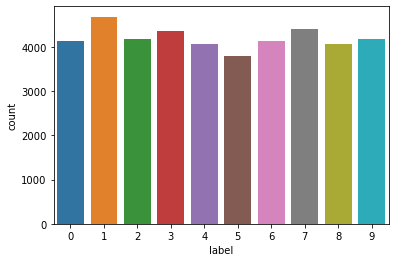

In [5]:
sns.countplot(data = df, x = "label")

In [44]:
class MNIST(Dataset):
    
    def __len__(self):
        return len(df)
    
    def __getitem__(self, idx):
        tensor, label = torch.tensor(df.loc[idx, df.columns != "label"].to_numpy()).view(1, 28, 28), df.loc[idx, "label"]
        return tensor.float(), label
    
dataset = MNIST()

train_proportion = 0.7
train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * train_proportion), len(dataset) - int(len(dataset) * train_proportion)])


train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

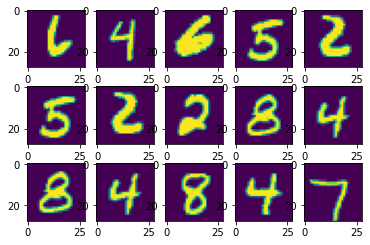

In [7]:
features, labels = next(iter(train_dataloader))

height, width = 3, 5
fig, ax = plt.subplots(height, width)

for i in range(height):
    for j in range(width):
        ax[i, j].imshow(features[i * 3 + j].permute(1, 2, 0))
    

In [50]:
class digitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #self.fc1 = nn.Linear(16 * 10 * 10, 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        #plt.imshow(x.detach().numpy()[0][0])
        #plt.show()
        
        x = x.view(-1, 16 * 5 * 5)
        #x = x.view(-1, 16 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(x)
        
        return x
    

model = digitCNN()
summary(model)
pass

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            2,416
├─Linear: 1-3                            48,120
├─Linear: 1-4                            10,164
├─Linear: 1-5                            850
├─MaxPool2d: 1-6                         --
├─MaxPool2d: 1-7                         --
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [52]:
epochs = 5
losses = []
for epoch in range(epochs):
    print(f"------ epoch n°{epoch} ------")
    for b, batch in enumerate(train_dataloader): # for each batch
        features, labels = batch
        
        labels = labels.long()
        
        # Zero the gradient
        optimizer.zero_grad()
        
        # Pass inputs to model
        predictions = model(features)
        
        # Get the loss
        loss = criterion(predictions, labels)
        
        # back propagate
        loss.backward()
        
        # optimize model parameters
        optimizer.step()
        
        losses.append(loss.item())
        
        if b % 50 == 0:
            print(f"batch n°{b}, loss is {loss.item()}")

    # compute validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (X_test, y_test) in enumerate(test_dataloader):
            val_prediction = model(X_test)
            val_loss += criterion(val_prediction, y_test).item()
        print("val loss", val_loss)

        model.train()

------ epoch n°0 ------
batch n°0, loss is 20.020912170410156


<ipython-input-50-f32038b9348b>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


batch n°50, loss is 2.7896671295166016
batch n°100, loss is 1.2880425453186035
batch n°150, loss is 0.890862762928009
batch n°200, loss is 0.218528151512146
batch n°250, loss is 0.2042928785085678
batch n°300, loss is 0.18963606655597687
batch n°350, loss is 0.16525059938430786
batch n°400, loss is 0.39478471875190735
batch n°450, loss is 0.2567664682865143
val loss 47.525389172136784
------ epoch n°1 ------
batch n°0, loss is 0.12488456815481186
batch n°50, loss is 0.22426699101924896
batch n°100, loss is 0.10528776049613953
batch n°150, loss is 0.1312250941991806
batch n°200, loss is 0.02431854046881199
batch n°250, loss is 0.17527857422828674
batch n°300, loss is 0.23397162556648254
batch n°350, loss is 0.11819861084222794
batch n°400, loss is 0.21889330446720123
batch n°450, loss is 0.22327551245689392
val loss 31.512173555791378
------ epoch n°2 ------
batch n°0, loss is 0.1401716023683548
batch n°50, loss is 0.14513392746448517
batch n°100, loss is 0.07336690276861191
batch n°150

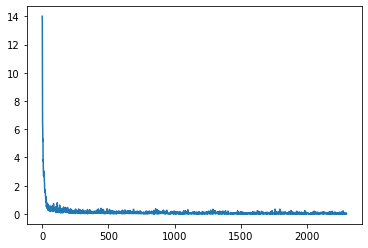

In [32]:
plt.plot(losses)
plt.show()

In [58]:
# desactivate dropout layers and batch normalization
model.eval()

# desactivate gradient tracking
with torch.no_grad():
    eval_loss = 0
    for i, (X_test, y_test) in enumerate(test_dataloader):
        outputs = model(X_test)
        
        # get the predicted class as an int
        _, predictions = torch.max(outputs, 1)
        
        nb_correct += (predictions == y_test).sum().item()
        print(len(y_test))
        n += len(y_test)
        
    
    

<ipython-input-50-f32038b9348b>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


63
64
63
62
64
59
63
61
64
61
61
61
63
62
62
63
62
61
61
64
63
62
61
62
62
64
62
63
63
62
62
62
63
60
62
64
59
62
61
61
61
63
63
63
62
63
61
64
61
61
61
63
64
64
62
61
61
61
62
62
63
59


KeyboardInterrupt: 